## Fastcluster를 이용해 파이썬에서 clustermap 빨리 그리기
---
파이썬(Pyhton)에서 속도 문제는 언제나 뜨거운 감자입니다. 못쓸 정도는 아니지만, 그렇다고 해서 쾌적한 속도를 보여주지도 않기 때문에 빅데이터 분석을 할 때는 언제나 속도 최적화 과정과 병렬 처리에 대한 지식을 잘 알아야 하기 때문입니다.  
</p></br></br>


그리고, 이러한 노력은 다양한 프로그래머의 노력으로 더욱 편리한 패키지로 탄생하고 있습니다. 저는 최근에 클러스터맵(Clustermap)을 그릴 일이 생겼는데, 옛날 코드를 쓰려고 보니 특이한 안내메시지가 하나 보이더라고요. Fastcluster를 쓰면 Clustermap을 더 빨리 그릴 수 있다는 말이었습니다.  
</p></br></br>


과연 얼마나 빨라질지 궁금해서, 제가 이전에 사용했던 클러스터맵 코드를 이용해 테스트를 해 봤습니다. 만약 이 코드를 따라하고 싶다면, 아래 코드 또는 깃허브에서 ipynb 파일을 다운로드한 뒤 실행해 보시기 바랍니다.  
</p></br></br>


* Transcription profiling by high throughput sequencing from seedling, root, and floral buds of 17 Arabidopsis thaliana accessions 데이터
* Source: https://www.ebi.ac.uk/gxa/experiments/E-GEOD-53197/Downloads (TPM file)  
</p></br></br>



In [1]:
# 패키지 불러오기

import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [5]:
ara_17 = pd.read_csv('./Data/Arabidopsis_17/E-GEOD-53197-query-results.tpms.tsv',
                     sep='\t', comment='#', index_col=1)

ara_17 = ara_17.iloc[:, 1:]
# 계산 편의상 missing value를 0으로 치환한다
ara_17 = ara_17.fillna(0)

X = ara_17.values.T

part = [x.split(', ')[1] for x in ara_17.columns]
part = list(set(part))  # 중복되는 요소를 합친 후 리스트화

y = [part.index(x.split(', ')[1]) for x in ara_17.columns]

In [6]:
rfc = RandomForestClassifier(n_estimators=2000, random_state=0)
rfc.fit(X, y)

RandomForestClassifier(n_estimators=2000, random_state=0)

In [7]:
m = rfc.feature_importances_ > 0
ara_17_fi = ara_17.index[m]

C:\ProgramData\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


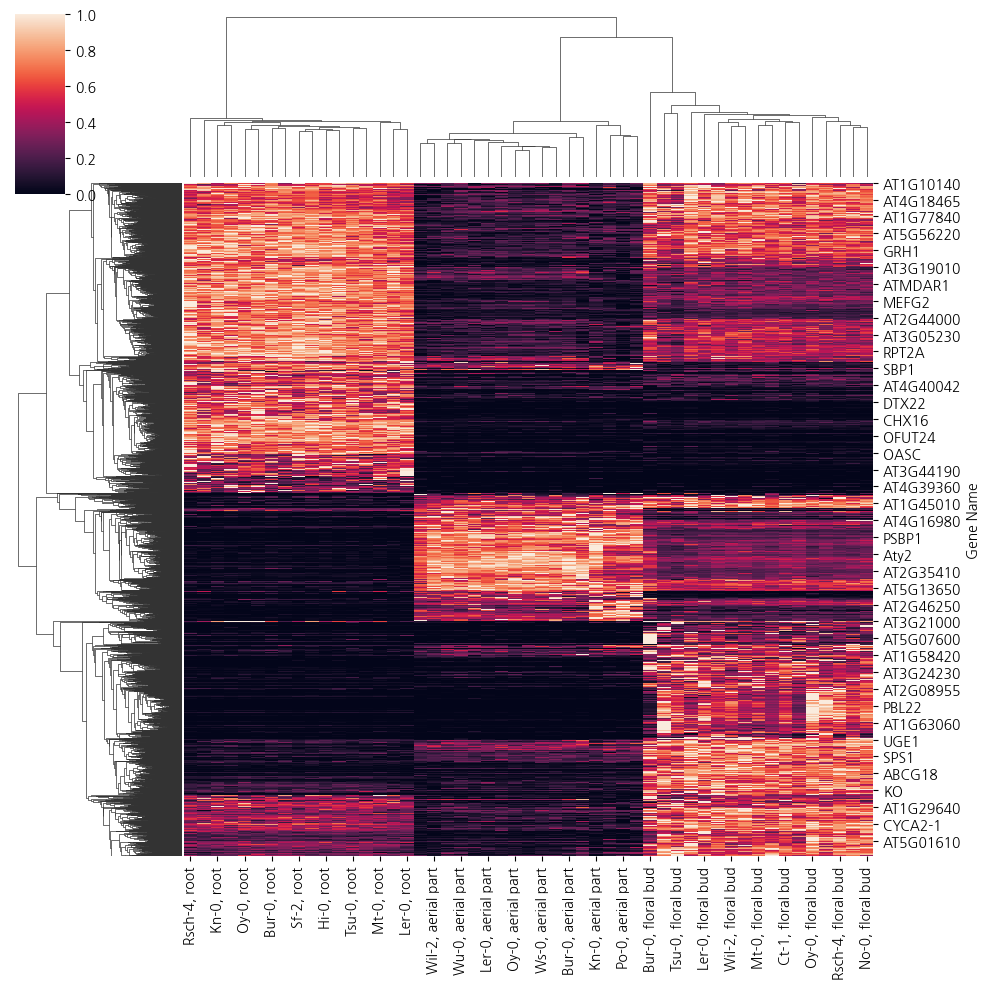

In [8]:
sns.clustermap(ara_17.loc[ara_17_fi], standard_scale=0)

</p></br></br>


위 코드에서 마지막 셀을 실행하면 클러스터맵이 생성되는데, 여기에 걸리는 시간을 측정해 보겠습니다. jupyter에서는 `%%timeit` 이라는 매직 커맨드(Magic Command)가 있는데, 이건 `%%timeit` 이 입력된 셀을 수 차례 실행한 뒤 소요시간의 평균을 측정해 주는 코드랍니다.
</p></br></br>


참고로, `%%timeit` 은 특성상 코드를 여러 차례 실행하기 때문에, 생성된 클러스터맵이 잔뜩 쌓이지 않도록 클러스터맵이 그려진 뒤 지우도록 `plt.clf()` 함수를 맨 아래에 덧붙여 줬습니다. 어차피 도표를 그린 뒤 지우는 것이니 성능 테스트에 문제는 없답니다.
</p></br></br>



In [9]:
%%timeit
sns.clustermap(ara_17.loc[ara_17_fi], standard_scale=0)
plt.clf()

C:\ProgramData\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\seaborn

1.07 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

</p></br></br>


해당 클러스터맵을 그리는데는 1.07 s ± 18 ms 의 시간이 소요되었다고 합니다. 딱히 느리지는 않지만, 큰 데이터를 입력할 경우에는 기하급수적으로, 어쩌면 그 이상으로 느려질 수 있습니다. 그렇기 때문에, Fastcluster를 이용해서 한번 테스트를 해 보겠습니다. Fastcluster는 쉘 스크립트에 `$ pip install fastcluster` 를 입력해 설치해 주시면 됩니다.  
</p></br></br>



In [13]:
%%timeit

sns.clustermap(ara_17.loc[ara_17_fi], standard_scale=0)
plt.clf()

1.06 s ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

</p></br></br>


이번 클러스터맵 코드는 1.06 s ± 29.5 ms 의 시간이 소요되었다고 합니다. 사실상 속도의 차이를 보이지 않는것 같은데, 더욱 크기가 큰 데이터프레임을 입력한다면 유의미한 속도 차이가 날지도 모르겠습니다.  
</p></br></br>


Fastcluster는 다른 벤치마크 결과를 살펴보면 규모가 큰 데이터에 대해서 상당히 빠른 속도를 보여줍니다. 저는 아마 다른 클러스터링 알고리즘과 별로 차이가 나지 않을 정도로 작은 데이터를 이용한 것으로 보이는데요, 자세한 내용은 아래 도표와 [벤치마크 문서](https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html)를 참고해 보시기 바랍니다.  
</p></br></br>


<img src="https://hdbscan.readthedocs.io/en/latest/_images/performance_and_scalability_9_1.png">